In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [6]:
# Convert to numerical data
df_encoded = pd.get_dummies(df,columns=['pymnt_plan','hardship_flag','debt_settlement_flag',
                                        'initial_list_status', 'application_type','next_pymnt_d'])
months = {'Jan-2019':1,
         'Feb-2019':2,
         'Mar-2019':3
         }
df_encoded['month']=df_encoded['issue_d'].apply(lambda x: months[x])

home_own_list = {'RENT':1,
           'MORTGAGE':2,
           'ANY':3,
            'OWN':4                 
           }
df_encoded['home_own'] = df_encoded['home_ownership'].apply(lambda x: home_own_list[x])

verification_stat_list = {'Not Verified':0,
                        'Verified':1,
                        'Source Verified':1}
df_encoded['verification_stat']=df_encoded['verification_status'].apply(lambda x: verification_stat_list[x])


#df_encoded['loan_status']=df_encoded['loan_status_high_risk']
df_encoded['next_pymnt_May']=df_encoded['next_pymnt_d_Apr-2019']
df_encoded['joint_app_type']=df_encoded['application_type_Joint App']
df_encoded = df_encoded.drop(['issue_d','home_ownership','next_pymnt_d_May-2019',
                              'next_pymnt_d_Apr-2019','application_type_Individual','application_type_Joint App',
                             'initial_list_status_f','verification_status'], axis = 1)

pd.set_option('display.max_columns',None)
df_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,pymnt_plan_n,hardship_flag_N,debt_settlement_flag_N,initial_list_status_w,month,home_own,verification_stat,next_pymnt_May,joint_app_type
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,1609.0,14.0,10204.87,10204.87,355.29,355.29,295.13,60.16,0.0,0.0,0.0,375.35,0.0,1.0,0.0,178.0,38199.0,3.0,4.0,2.0,4.0,3.0,36590.0,59.0,1.0,2.0,1553.0,58.0,3700.0,1.0,0.0,4.0,6.0,4775.0,447.0,77.7,0.0,0.0,93.0,96.0,3.0,3.0,0.0,20.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,3.0,3.0,2.0,8.0,0.0,0.0,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,1,1,1,1,3,1,1,0,0
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,18368.0,34.0,24293.13,24293.13,873.53,873.53,706.87,166.66,0.0,0.0,0.0,929.09,0.0,1.0,0.0,165.0,228119.0,3.0,3.0,2.0,3.0,4.0,42273.0,86.0,4.0,8.0,5197.0,61.0,50400.0,4.0,9.0,3.0,13.0,13419.0,29502.0,28.4,0.0,0.0,87.0,286.0,1.0,1.0,2.0,1.0,11.0,3.0,7.0,11.0,8.0,13.0,14.0,13.0,18.0,11.0,17.0,0.0,0.0,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,1,1,1,1,3,2,1,0,0
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,13247.0,21.0,19636.79,19636.79,485.44,485.44,363.21,122.23,0.0,0.0,0.0,529.88,0.0,1.0,0.0,0.0,45684.0,2.0,3.0,2.0,3.0,4.0,32437.0,75.0,2.0,3.0,2810.0,75.0,17500.0,0.0,4.0,1.0,6.0,5711.0,2839.0,62.1,0.0,0.0,159.0,156.0,7.0,4.0,0.0,7.0,7.0,6.0,2.0,5.0,2.0,7.0,8.0,5.0,13.0,5.0,8.0,0.0,0.0,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,1,1,1,1,3,2,1,0,0
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,17996.0,23.0,9719.34,9719.34,335.33,335.33,280.66,54.67,0.0,0.0,0.0,353.55,0.0,1.0,0.0,0.0,68784.0,0.0,4.0,1.0,3.0,9.0,50788.0,66.0,0.0,1.0,6360.0,69.0,23000.0,3.0,5.0,4.0,4.0,6878.0,4899.0,75.1,0.0,0.0,100.0,89.0,24.0,9.0,0.0,34.0,0.0,0.0,4.0,6.0,4.0,4.0,17.0,6.0,6.0,6.0,10.0,0.0,0.0,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,1,1,1,1,3,1,1,0,0
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,9091.0,28.0,21614.73,21614.73,484.36,484.36,385.27,99.09,0.0,0.0,0.0,520.39,0.0,1.0,0.0,0.0,177745.0,0.0,1.0,0.0,2.0,14.0,16828.0,84.0,1.0,1.0,3600.0,41.0,43100.0,2.0,0.0,2.0,4.0,13673.0,19699.0,28.6,0.0,0.0,67.0,138.0,11.0,11.0,4.0,11.0,0.0,0.0,4.0,6.0,7.0,11.0,6.0,12.0,18.0,6.0,14.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,1,1,1,1,3,2,0,0,0


# Split the Data into Training and Testing

In [7]:
# Create our features
X = df_encoded.copy()
X = X.drop('loan_status', axis = 1)
X.head()

# Create our target
y = df_encoded['loan_status']

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,pymnt_plan_n,hardship_flag_N,debt_settlement_flag_N,initial_list_status_w,month,home_own,verification_stat,next_pymnt_May,joint_app_type
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.000000,68817.000000,68817.0,68817.0,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.00000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.0,68817.0,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,24.666347,16018.845833,16015.919519,970.639473,970.431151,658.748750,311.855687,0.035072,0.0,0.0,517.202218,0.016188,1.0,0.0,188.664298,1.634976e+05,1.023047,3.290481,0.843730,1.909644,14.303152,4.324044e+04,69.21191,1.240042,2.622245,6297.491710,55.702472,42431.895360,1.382071,1.687795,2.189023,4.827572,14142.936193,16991.852667,48.330667,0.006830,2.347065,125.468605,175.136841,14.294215,7.179781,1.441882,24.714954,7.688028,0.472485,3.806123,5.648038,5.135156,7.414403,9.500153,8.630818,13.517663,5.653036,12.571995,0.0,0.0,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,1.0,1.0,1.0,0.876121,1.726172,1.865121,0.521993,0.383161,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,12.318917,10002.695495,10004.985940,1229.563301,1229.569864,1126.237377,279.786954,1.086720,0.0,0.0,816.021053,0.134774,0.0,0.0,1808.457195,1.723699e+05,1.176782,2.965579,0.970543,1.544994,13.972619,4.956130e+04,22.33711,1.471745,2.502608,5702.281757,18.495480,37166.229316,1.543220,2.852664,2.396186,3.145377,15863.878993,20447.276820,28.106287,0.087327,301.312407,56.968853,99.149467,17.417118,6.303066,1.747777,32.130889,6.034861,1.410819,2.464504,3.470941,3.230651,4.581371,7.573846,5.056994,8.026158,3.472679,6.021318,0.0,0.0,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,0.0,0.0,0.0,0.329446,0.743862,0.880767,0.499520,0.486161,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000

In [9]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [11]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [12]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
clf = BalancedRandomForestClassifier(n_estimators = 100, random_state=1)
clf.fit(X_train_scaled, y_train)  

BalancedRandomForestClassifier(random_state=1)

In [14]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)


0.7488752558604785

In [15]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[   65,    36],
       [ 2494, 14610]], dtype=int64)

In [16]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.64      0.85      0.05      0.74      0.54       101
   low_risk       1.00      0.85      0.64      0.92      0.74      0.56     17104

avg / total       0.99      0.85      0.64      0.92      0.74      0.56     17205



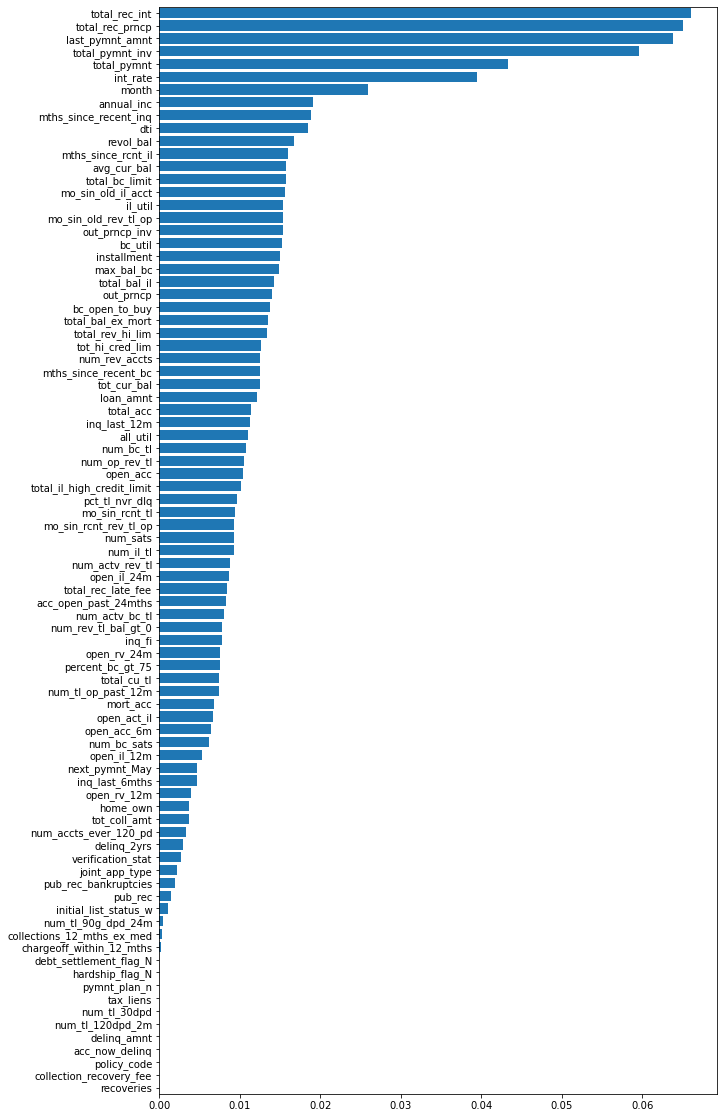

In [17]:
# List the features sorted in descending order by feature importance

features = sorted(clf.feature_importances_, reverse = True)
#print(features)

features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()
fig.set_size_inches(10,20)
plt.margins(y=0.001)
ax.barh(y=cols, width=width)
plt.show()

### Easy Ensemble AdaBoost Classifier

In [18]:
# Train the EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1, n_estimators = 100).fit(X_train_scaled, y_train)


In [19]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.6879726472413378

In [20]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[   38,    63],
       [    5, 17099]], dtype=int64)

In [21]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.88      0.38      1.00      0.53      0.61      0.35       101
   low_risk       1.00      1.00      0.38      1.00      0.61      0.40     17104

avg / total       1.00      1.00      0.38      1.00      0.61      0.40     17205

